Combine data from DMI & Energinet
=======================
This loads in csv file created by the [loadbulkweather.ipynb](loadbulkweather.ipynb) and pulls data from the Energinet API

In [1]:
import pandas as pd

import assetpricing_functions as ap
%load_ext autoreload
%autoreload 2

## Loading DMI data

In [2]:
# path to the CSV file
path = '/Users/johan/Documents/04 Div Uni/09 Asset Pricing Data/weather-muni/weather_data.csv'
path_out = '../../data/fulldata.csv'

# read the data
df_weather = pd.read_csv(path)

In [3]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11856625 entries, 0 to 11856624
Data columns (total 25 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   municipalityId                int64  
 1   municipalityName              object 
 2   from                          object 
 3   to                            object 
 4   geometry_type                 object 
 5   coordinates                   object 
 6   mean_radiation                float64
 7   mean_wind_speed               float64
 8   acc_precip                    float64
 9   temp_soil_10                  float64
 10  max_wind_speed_3sec           float64
 11  temp_grass                    float64
 12  max_temp_w_date               float64
 13  mean_relative_hum             float64
 14  max_wind_speed_10min          float64
 15  mean_cloud_cover              float64
 16  leaf_moisture                 float64
 17  mean_temp                     float64
 18  vapour_pressure_defi

In [4]:
# count nan values in each column
print(df_weather.isna().sum()) 

municipalityId                        0
municipalityName                      0
from                                  0
to                                    0
geometry_type                         0
coordinates                           0
mean_radiation                     1542
mean_wind_speed                      74
acc_precip                           76
temp_soil_10                    3441637
max_wind_speed_3sec                4590
temp_grass                      3439285
max_temp_w_date                      75
mean_relative_hum                    79
max_wind_speed_10min                 87
mean_cloud_cover                4323348
leaf_moisture                   3610198
mean_temp                            79
vapour_pressure_deficit_mean    6014341
no_lightning_strikes                 76
mean_pressure                        74
min_temp                             75
temp_soil_30                    3444681
mean_wind_dir                        76
bright_sunshine                    1542


In [5]:
# define ids
if 'cellId' in df_weather.columns:
    ids = ['cellId']
if 'municipalityId' in df_weather.columns:
    ids = ['municipalityName','municipalityId']

# convert to datetime
df_weather['from'] = pd.to_datetime(df_weather['from'])
df_weather['to'] = pd.to_datetime(df_weather['to'])

# columns to keep
cols = ids + ['from', 'to', 'coordinates', 'geometry_type', # general columns
              'mean_temp', # temperature data
              'mean_wind_speed', 'mean_wind_dir', # wind data
            #   'mean_cloud_cover', 'bright_sunshine', # cloud and sunshine data
              ]

# keep only the columns we need
df_weather = df_weather[cols]

# rename columns
df_weather.rename(columns={'mean_temp':'temp','mean_wind_speed':'wind_speed'}, inplace=True)

# adding electricity area to the dataframe DK1 is the price area for west Denmark, DK2 is for east Denmark https://energinet.dk/El/Systemydelser/Introduktion-til-Systemydelser/Oversigt-over-systemydelser/
if 'cellId' in df_weather.columns:
    df_weather['area'] = df_weather['cellId'].apply(lambda x: 'DK1' if int(x[-2:]) < 62 else 'DK2')
elif 'municipalityId' in df_weather.columns:
    df_weather['area'] = df_weather['municipalityId'].apply(lambda x: 'DK1' if x > 400 else 'DK2')

display(df_weather.head())

,municipalityName,municipalityId,from,to,coordinates,geometry_type,temp,wind_speed,mean_wind_dir,area
0,København,101,2010-12-31 23:00:00+00:00,2011-01-01 00:00:00+00:00,"[12.49390862, 55.7040906]",Point,3.1,10.0,250.0,DK2
1,Frederiksberg,147,2010-12-31 23:00:00+00:00,2011-01-01 00:00:00+00:00,"[12.52373306, 55.67936546]",Point,3.2,9.7,248.0,DK2
2,Ballerup,151,2010-12-31 23:00:00+00:00,2011-01-01 00:00:00+00:00,"[12.36840182, 55.72775072]",Point,2.9,10.6,258.0,DK2
3,Brøndby,153,2010-12-31 23:00:00+00:00,2011-01-01 00:00:00+00:00,"[12.40438199, 55.64503727]",Point,3.1,10.4,253.0,DK2
4,Dragør,155,2010-12-31 23:00:00+00:00,2011-01-01 00:00:00+00:00,"[12.65022813, 55.59380739]",Point,3.1,11.8,259.0,DK2


In [6]:
# create a fact table with information on municipalities
df_facts = df_weather[ids + ['area','coordinates','geometry_type']].drop_duplicates()

In [7]:
# count nan values in each column
print(df_weather.isna().sum()) 

# print rows with missing values
na_vals = df_weather[df_weather.isnull().any(axis=1)]
display(na_vals.head())

municipalityName     0
municipalityId       0
from                 0
to                   0
coordinates          0
geometry_type        0
temp                79
wind_speed          74
mean_wind_dir       76
area                 0
dtype: int64


,municipalityName,municipalityId,from,to,coordinates,geometry_type,temp,wind_speed,mean_wind_dir,area
6176450,København,101,2018-03-11 07:00:00+00:00,2018-03-11 08:00:00+00:00,"[12.49390862, 55.7040906]",Point,NaN,NaN,NaN,DK2
6176451,Frederiksberg,147,2018-03-11 07:00:00+00:00,2018-03-11 08:00:00+00:00,"[12.52373306, 55.67936546]",Point,NaN,4.0,NaN,DK2
6176452,Ballerup,151,2018-03-11 07:00:00+00:00,2018-03-11 08:00:00+00:00,"[12.36840182, 55.72775072]",Point,NaN,NaN,NaN,DK2
6176453,Brøndby,153,2018-03-11 07:00:00+00:00,2018-03-11 08:00:00+00:00,"[12.40438199, 55.64503727]",Point,NaN,4.4,NaN,DK2
6176454,Dragør,155,2018-03-11 07:00:00+00:00,2018-03-11 08:00:00+00:00,"[12.65022813, 55.59380739]",Point,NaN,3.1,NaN,DK2


In [8]:
# controlling for values completely missing
control = df_weather[['from', 'to']].apply(pd.to_datetime).drop_duplicates()
control.set_index('from', inplace=True)

# Create a complete date range from the start to the end of your data
full_range = pd.date_range(start=control.index.min(), end=control.index.max(), freq='h')

# Reindex your DataFrame to this full range
df_reindexed = control.reindex(full_range)

# Identify missing hours
missing_hours = df_reindexed[df_reindexed.isnull().any(axis=1)]

print("Missing hours:")
print(missing_hours.index)

Missing hours:
DatetimeIndex(['2018-03-11 00:00:00+00:00', '2018-03-11 01:00:00+00:00',
               '2018-03-11 02:00:00+00:00', '2018-03-11 03:00:00+00:00',
               '2018-03-11 04:00:00+00:00', '2018-03-11 05:00:00+00:00',
               '2018-03-11 06:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='h')


In [9]:
# adding missing hours
if missing_hours.shape[0] < 720:
    # Ensure 'from' is in datetime format
    df_weather['from'] = pd.to_datetime(df_weather['from'])

    # original shape
    shape_original = df_weather.shape

    # Get the min and max 'from' dates per ID
    min_max_dates = df_weather.groupby(ids[0])['from'].agg(['min', 'max']).reset_index()

    # For each ID, create a DataFrame with all hourly 'from' timestamps between min and max dates
    date_ranges = []
    for idx, row in min_max_dates.iterrows():
        id_value = row[ids[0]]
        start_date = row['min']
        end_date = row['max']
        date_range = pd.date_range(start=start_date, end=end_date, freq='h')
        df_id = pd.DataFrame({ids[0]: id_value, 'from': date_range})
        date_ranges.append(df_id)

    # Concatenate all date ranges into a single DataFrame
    df_all_hours = pd.concat(date_ranges, ignore_index=True)

    # Merge the original data with the full hourly data
    df_weather = pd.merge(df_all_hours, df_weather, on=[ids[0], 'from'], how='left')

    # Create the 'to' column by adding one hour to 'from'
    df_weather['to'] = df_weather['from'] + pd.DateOffset(hours=1)

    # Optional: Sort the DataFrame
    df_weather.sort_values(by=['from', ids[0]], inplace=True)

    # reset index
    df_weather.reset_index(drop=True, inplace=True)

    # new shape
    shape_new = df_weather.shape

    print(f"Added {shape_new[0] - shape_original[0]} rows")

Added 689 rows


In [10]:
# adding the missing values
df_weather = pd.merge(df_weather, df_facts, on=ids[0], how='left')

# Remove columns that end with '_x'
df_weather = df_weather.drop(columns=[col for col in df_weather.columns if col.endswith('_x')])

# Rename columns that end with '_y' by removing the '_y' suffix
df_weather = df_weather.rename(columns=lambda x: x[:-2] if x.endswith('_y') else x)

In [11]:
# Select only float columns for interpolation
float_columns = df_weather.select_dtypes(include=['float']).columns

# Count NaN values across all float columns
nan_count = df_weather[float_columns].isna().sum().sum()
print(f'Total NaN values: {nan_count}')

# Check if NaN values exceed 10,000
if nan_count > 10000:
    # Create a boolean mask for rows with NaN values in any float column
    nan_mask = df_weather[float_columns].isna().any(axis=1)
    # Find the last NaN date
    last_nan_date = df_weather['from'][nan_mask].iloc[-1]
    # Drop all rows before the last NaN date
    df_weather = df_weather[df_weather['from'] > last_nan_date].copy()

    print(f'Dropped all rows before {last_nan_date}, none interpolated')

else:
    for idx in df_weather[ids[0]].unique():
        df_weather.loc[df_weather[ids[0]] == idx, float_columns] = df_weather.loc[df_weather[ids[0]] == idx, float_columns].interpolate()
    
    print(f'A total of {nan_count} NaN values were interpolated')

# check if na values are gone
print(f'Total NaN values left: {df_weather[float_columns].isna().sum().sum()}')

display(df_weather)

Total NaN values: 2296
A total of 2296 NaN values were interpolated
Total NaN values left: 0


,municipalityName,from,to,temp,wind_speed,mean_wind_dir,municipalityId,area,coordinates,geometry_type
0,Aabenraa,2010-12-31 23:00:00+00:00,2011-01-01 00:00:00+00:00,3.1,12.5,253.0,580,DK1,"[9.27705335, 54.95857106]",Point
1,Aalborg,2010-12-31 23:00:00+00:00,2011-01-01 00:00:00+00:00,3.8,12.9,284.0,851,DK1,"[9.99710026, 56.98086976]",Point
2,Aarhus,2010-12-31 23:00:00+00:00,2011-01-01 00:00:00+00:00,4.1,10.1,274.0,751,DK1,"[10.10360521, 56.15511031]",Point
3,Albertslund,2010-12-31 23:00:00+00:00,2011-01-01 00:00:00+00:00,2.9,11.1,257.0,165,DK2,"[12.35232083, 55.68497735]",Point
4,Allerød,2010-12-31 23:00:00+00:00,2011-01-01 00:00:00+00:00,2.7,11.1,261.0,201,DK2,"[12.31517796, 55.85193129]",Point
...,...,...,...,...,...,...,...,...,...,...
11857309,Vejle,2024-10-20 07:00:00+00:00,2024-10-20 08:00:00+00:00,12.4,3.3,173.0,630,DK1,"[9.36401747, 55.69959549]",Point
11857310,Vesthimmerlands,2024-10-20 07:00:00+00:00,2024-10-20 08:00:00+00:00,12.9,5.9,169.0,820,DK1,"[9.38374995, 56.81543648]",Point
11857311,Viborg,2024-10-20 07:00:00+00:00,2024-10-20 08:00:00+00:00,12.9,4.8,173.0,791,DK1,"[9.54980131, 56.47080654]",Point
11857312,Vordingborg,2024-10-20 07:00:00+00:00,2024-10-20 08:00:00+00:00,13.3,3.3,179.0,390,DK2,"[11.97379373, 55.06464257]",Point


In [12]:
df_weather['wind_dir'] = df_weather['mean_wind_dir'].apply(ap.degrees_to_cardinal)

display(df_weather.head())

,municipalityName,from,to,temp,wind_speed,mean_wind_dir,municipalityId,area,coordinates,geometry_type,wind_dir
0,Aabenraa,2010-12-31 23:00:00+00:00,2011-01-01 00:00:00+00:00,3.1,12.5,253.0,580,DK1,"[9.27705335, 54.95857106]",Point,W
1,Aalborg,2010-12-31 23:00:00+00:00,2011-01-01 00:00:00+00:00,3.8,12.9,284.0,851,DK1,"[9.99710026, 56.98086976]",Point,W
2,Aarhus,2010-12-31 23:00:00+00:00,2011-01-01 00:00:00+00:00,4.1,10.1,274.0,751,DK1,"[10.10360521, 56.15511031]",Point,W
3,Albertslund,2010-12-31 23:00:00+00:00,2011-01-01 00:00:00+00:00,2.9,11.1,257.0,165,DK2,"[12.35232083, 55.68497735]",Point,W
4,Allerød,2010-12-31 23:00:00+00:00,2011-01-01 00:00:00+00:00,2.7,11.1,261.0,201,DK2,"[12.31517796, 55.85193129]",Point,W


In [13]:
ap.plot_map(df_facts,id=ids[0],color_by='area', save='map.png', do_print=False)

Map saved as: output/map.png


In [14]:
# removing dk2 as we will only use dk1
df_weather_dk1 = df_weather[df_weather['area'] == 'DK1'].drop(columns=['area','coordinates','mean_wind_dir'], axis=1)

# create wind direction dummies
df_weather_dk1 = pd.get_dummies(df_weather_dk1, columns=['wind_dir'], prefix='wind_dir')

# reset index
df_weather_dk1.reset_index(drop=True, inplace=True)

In [15]:
# print info
print(df_weather_dk1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6291636 entries, 0 to 6291635
Data columns (total 15 columns):
 #   Column            Dtype              
---  ------            -----              
 0   municipalityName  object             
 1   from              datetime64[ns, UTC]
 2   to                datetime64[ns, UTC]
 3   temp              float64            
 4   wind_speed        float64            
 5   municipalityId    int64              
 6   geometry_type     object             
 7   wind_dir_E        bool               
 8   wind_dir_N        bool               
 9   wind_dir_NE       bool               
 10  wind_dir_NW       bool               
 11  wind_dir_S        bool               
 12  wind_dir_SE       bool               
 13  wind_dir_SW       bool               
 14  wind_dir_W        bool               
dtypes: bool(8), datetime64[ns, UTC](2), float64(2), int64(1), object(2)
memory usage: 384.0+ MB
None


In [16]:
# print figure of mean temperature data for DK1
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
for municipality, group_data in df_weather_dk1.groupby('municipalityName'):
    plt.plot(group_data['from'], group_data['temp'], label=municipality, alpha=0.8)

# Adding titles and labels
plt.xlabel('Date', fontsize=26)
plt.ylabel('Mean Temperature (°C)', fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.grid(True)
plt.tight_layout()

plt.savefig('output/mean_temp.png')
plt.close()

In [17]:
# print figure of mean wind speed data for DK1
plt.figure(figsize=(14, 8))
for municipality, group_data in df_weather_dk1.groupby('municipalityName'):
    plt.plot(group_data['from'], group_data['wind_speed'], label=municipality, alpha=0.8)

# Adding titles and labels
plt.xlabel('Date', fontsize=26)
plt.ylabel('Mean Wind Speed (m/s)', fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.grid(True)
plt.tight_layout()

plt.savefig('output/mean_wind_speed.png')
plt.close()

In [18]:
df_wide_dk1 = df_weather_dk1.pivot_table(index=['from','to'], columns=ids[0], 
                                             values=['temp', 'wind_speed',
                                                     'wind_dir_N', 'wind_dir_NE', 'wind_dir_E', 
                                                     'wind_dir_SE', 'wind_dir_S', 'wind_dir_SW',
                                                      'wind_dir_W'], # 'wind_dir_NW' is dropped as it is the reference category 
                                             aggfunc='first').reset_index()

# column names
df_wide_dk1.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_wide_dk1.columns]

# rename columns
df_wide_dk1.rename(columns={'from_': 'from', 'to_': 'to'}, inplace=True)

df_wide_dk1

,from,to,temp_Aabenraa,temp_Aalborg,temp_Aarhus,temp_Assens,temp_Billund,temp_Brønderslev,temp_Esbjerg,temp_Faaborg-Midtfyn,...,wind_speed_Syddjurs,wind_speed_Sønderborg,wind_speed_Thisted,wind_speed_Tønder,wind_speed_Varde,wind_speed_Vejen,wind_speed_Vejle,wind_speed_Vesthimmerlands,wind_speed_Viborg,wind_speed_Ærø
0,2010-12-31 23:00:00+00:00,2011-01-01 00:00:00+00:00,3.1,3.8,4.1,3.3,3.6,3.8,3.1,3.3,...,11.6,11.3,14.0,12.0,11.3,9.5,10.6,13.4,12.3,12.1
1,2011-01-01 00:00:00+00:00,2011-01-01 01:00:00+00:00,3.1,3.5,3.9,3.4,3.8,3.4,3.3,3.4,...,14.0,11.1,14.9,12.1,10.6,8.6,10.4,13.7,11.1,12.2
2,2011-01-01 01:00:00+00:00,2011-01-01 02:00:00+00:00,3.1,3.7,3.8,3.6,3.7,3.4,3.5,3.5,...,13.8,10.3,16.2,11.5,10.3,8.7,9.4,14.7,11.7,11.9
3,2011-01-01 02:00:00+00:00,2011-01-01 03:00:00+00:00,3.1,3.7,3.7,3.5,3.6,3.7,3.0,3.5,...,13.2,9.3,16.4,9.6,9.9,7.8,9.7,14.6,12.7,10.4
4,2011-01-01 03:00:00+00:00,2011-01-01 04:00:00+00:00,2.7,3.8,3.8,3.4,3.1,3.8,2.9,3.4,...,13.5,9.8,15.8,9.9,11.3,8.3,10.1,13.7,12.1,10.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120988,2024-10-20 03:00:00+00:00,2024-10-20 04:00:00+00:00,12.5,11.4,11.9,12.5,12.3,11.3,12.4,12.5,...,3.2,3.3,5.8,4.2,5.6,3.4,3.2,4.7,4.2,4.5
120989,2024-10-20 04:00:00+00:00,2024-10-20 05:00:00+00:00,12.4,11.7,11.9,12.4,12.4,11.4,12.4,12.4,...,3.1,3.9,5.9,4.0,5.4,3.5,3.3,4.6,4.0,4.1
120990,2024-10-20 05:00:00+00:00,2024-10-20 06:00:00+00:00,12.3,11.9,11.9,12.2,12.4,11.7,12.4,12.0,...,3.0,3.2,6.4,3.8,4.7,3.7,3.5,5.1,4.2,3.9
120991,2024-10-20 06:00:00+00:00,2024-10-20 07:00:00+00:00,12.3,12.1,12.1,12.1,12.5,11.9,12.4,12.0,...,3.4,3.4,6.3,4.1,4.4,3.6,3.2,5.8,4.6,4.2


## Energinet data

--------
https://www.energidataservice.dk/tso-electricity/Elspotprices


In [19]:
# find the first date
start_date = df_wide_dk1['from'].min()
end_date = df_wide_dk1['to'].max()

# convert to YYYY-MM-DDTHH:MM string
start_date = start_date.strftime('%Y-%m-%dT%H:%M')
end_date = end_date.strftime('%Y-%m-%dT%H:%M')

# define url and parameters
base_url = 'https://api.energidataservice.dk/dataset/Elspotprices'
params = {
    'offset': 0,
    'start': start_date,
    'end': end_date,
    'filter': '{"PriceArea":["DK1"]}' # DK1 is the price area for west Denmark, DK2 is for east Denmark https://energinet.dk/El/Systemydelser/Introduktion-til-Systemydelser/Oversigt-over-systemydelser/
    }

In [20]:
# download the data
df_energy = ap.get_energydata(url=base_url, params=params)

# drop the HourDK column as dmi data is in UTC
df_energy.drop(columns=['HourDK', 'PriceArea', 'SpotPriceEUR'], inplace=True)

# convert to datetime
df_energy['HourUTC'] = pd.to_datetime(df_energy['HourUTC']).dt.tz_localize('UTC')
df_energy


,HourUTC,SpotPriceDKK
0,2024-10-20 05:00:00+00:00,291.329987
1,2024-10-20 04:00:00+00:00,240.389999
2,2024-10-20 03:00:00+00:00,241.880005
3,2024-10-20 02:00:00+00:00,444.450012
4,2024-10-20 01:00:00+00:00,417.000000
...,...,...
120987,2011-01-01 02:00:00+00:00,-11.400000
120988,2011-01-01 01:00:00+00:00,-11.400000
120989,2011-01-01 00:00:00+00:00,13.640000
120990,2010-12-31 23:00:00+00:00,2.380000


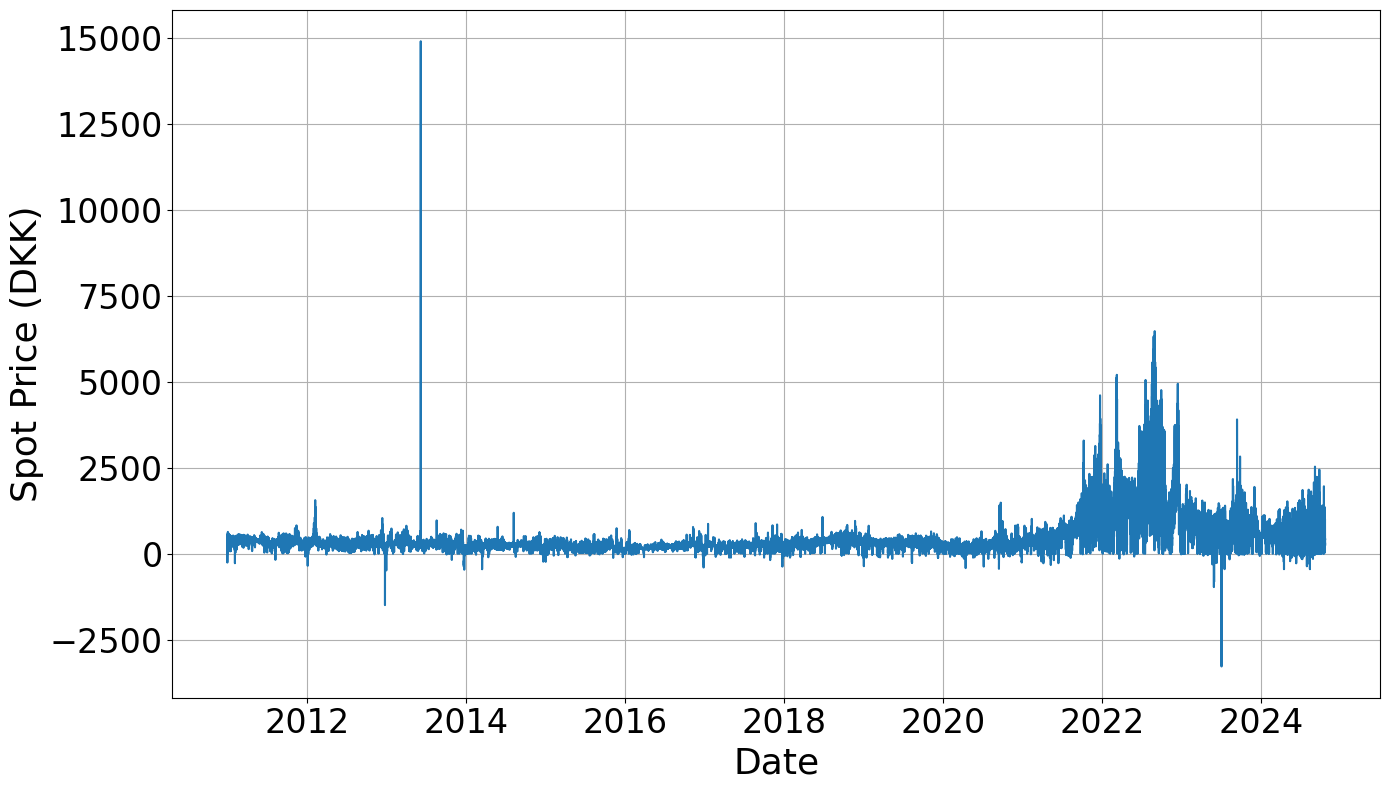

In [21]:
# print figure of mean wind speed data for DK1
plt.figure(figsize=(14, 8))
plt.plot(df_energy['HourUTC'], df_energy['SpotPriceDKK'])

# Adding titles and labels
plt.xlabel('Date', fontsize=26)
plt.ylabel('Spot Price (DKK)', fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.grid(True)
plt.tight_layout()

plt.savefig('output/spot_price_dkk.png')
plt.show()
plt.close()

## Combine datasets



In [22]:
# join on from and HourUTC
df = pd.merge(df_energy, df_wide_dk1, left_on=['HourUTC'], right_on=['from'], how='inner').drop(columns=['HourUTC'], axis=1)

display(df)

,SpotPriceDKK,from,to,temp_Aabenraa,temp_Aalborg,temp_Aarhus,temp_Assens,temp_Billund,temp_Brønderslev,temp_Esbjerg,...,wind_speed_Syddjurs,wind_speed_Sønderborg,wind_speed_Thisted,wind_speed_Tønder,wind_speed_Varde,wind_speed_Vejen,wind_speed_Vejle,wind_speed_Vesthimmerlands,wind_speed_Viborg,wind_speed_Ærø
0,291.329987,2024-10-20 05:00:00+00:00,2024-10-20 06:00:00+00:00,12.3,11.9,11.9,12.2,12.4,11.7,12.4,...,3.0,3.2,6.4,3.8,4.7,3.7,3.5,5.1,4.2,3.9
1,240.389999,2024-10-20 04:00:00+00:00,2024-10-20 05:00:00+00:00,12.4,11.7,11.9,12.4,12.4,11.4,12.4,...,3.1,3.9,5.9,4.0,5.4,3.5,3.3,4.6,4.0,4.1
2,241.880005,2024-10-20 03:00:00+00:00,2024-10-20 04:00:00+00:00,12.5,11.4,11.9,12.5,12.3,11.3,12.4,...,3.2,3.3,5.8,4.2,5.6,3.4,3.2,4.7,4.2,4.5
3,444.450012,2024-10-20 02:00:00+00:00,2024-10-20 03:00:00+00:00,12.4,11.4,11.6,12.5,12.0,11.5,12.4,...,2.5,3.3,5.7,4.2,5.2,3.4,3.2,4.8,4.0,4.4
4,417.000000,2024-10-20 01:00:00+00:00,2024-10-20 02:00:00+00:00,12.4,11.8,11.2,12.4,11.7,12.1,12.3,...,2.1,3.6,5.5,4.0,5.0,3.5,3.2,3.7,3.2,3.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120986,2.530000,2011-01-01 03:00:00+00:00,2011-01-01 04:00:00+00:00,2.7,3.8,3.8,3.4,3.1,3.8,2.9,...,13.5,9.8,15.8,9.9,11.3,8.3,10.1,13.7,12.1,10.1
120987,-11.400000,2011-01-01 02:00:00+00:00,2011-01-01 03:00:00+00:00,3.1,3.7,3.7,3.5,3.6,3.7,3.0,...,13.2,9.3,16.4,9.6,9.9,7.8,9.7,14.6,12.7,10.4
120988,-11.400000,2011-01-01 01:00:00+00:00,2011-01-01 02:00:00+00:00,3.1,3.7,3.8,3.6,3.7,3.4,3.5,...,13.8,10.3,16.2,11.5,10.3,8.7,9.4,14.7,11.7,11.9
120989,13.640000,2011-01-01 00:00:00+00:00,2011-01-01 01:00:00+00:00,3.1,3.5,3.9,3.4,3.8,3.4,3.3,...,14.0,11.1,14.9,12.1,10.6,8.6,10.4,13.7,11.1,12.2


In [23]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120991 entries, 0 to 120990
Columns: 471 entries, SpotPriceDKK to wind_speed_Ærø
dtypes: bool(364), datetime64[ns, UTC](2), float64(105)
memory usage: 140.8 MB
None


In [24]:
# save the data
df.to_csv(path_out, index=False)
print(f'Data saved to {path_out}')

Data saved to ../../data/fulldata.csv
